<a href="https://colab.research.google.com/github/rm-rf-humans/QNN/blob/main/H_QNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.5 MB/s eta 0:00:00


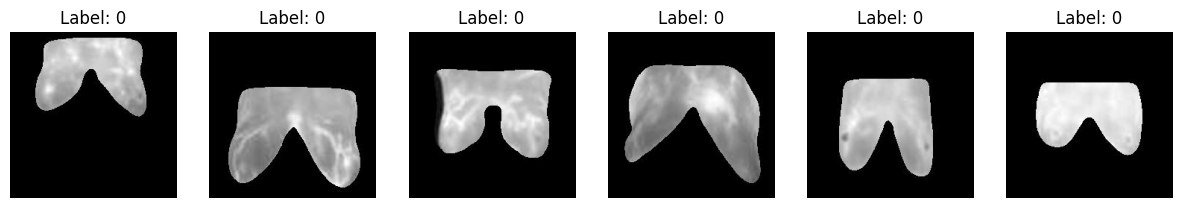

In [72]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import os
from sklearn.model_selection import train_test_split

class BreastCancerDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        label = 0 if 'normal' in img_path else 1  # Assuming the filename contains 'normal' or 'abnormal'

        if self.transform:
            image = self.transform(image)

        return image, label

normal_dir = "normal"
abnormal_dir = "abnormal"

normal_images = [
    os.path.join(normal_dir, img)
    for img in os.listdir(normal_dir)
    if img.endswith((".jpg", ".png"))  # Add image extensions
]
abnormal_images = [
    os.path.join(abnormal_dir, img)
    for img in os.listdir(abnormal_dir)
    if img.endswith((".jpg", ".png"))  # Add image extensions
]

# Labels: 0 for normal, 1 for abnormal
image_paths = normal_images + abnormal_images
labels = [0] * len(normal_images) + [1] * len(abnormal_images)

# Split data into training (70%), validation (15%), and test (15%) sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.3,
    random_state=42,
    stratify=labels,  # Stratify to maintain class distribution
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels,  # Stratify to maintain class distribution
)

# Define transforms
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Create datasets using the split paths
train_dataset = BreastCancerDataset(train_paths, transform=transform)
val_dataset = BreastCancerDataset(val_paths, transform=transform)
test_dataset = BreastCancerDataset(test_paths, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def show_samples(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image[0], cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

show_samples(train_dataset)


In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 2. Define Complex-Valued Operations
class ComplexConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ComplexConv2d, self).__init__()
        self.real = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.imag = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        real_out = self.real(real) - self.imag(imag)
        imag_out = self.real(imag) + self.imag(real)
        return torch.stack([real_out, imag_out], dim=1)

class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(ComplexLinear, self).__init__()
        self.real = nn.Linear(in_features, out_features)
        self.imag = nn.Linear(in_features, out_features)

    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        real_out = self.real(real) - self.imag(imag)
        imag_out = self.real(imag) + self.imag(real)
        return torch.stack([real_out, imag_out], dim=1)

class ComplexActivation(nn.Module):
    def __init__(self, activation_func):
        super(ComplexActivation, self).__init__()
        self.activation_func = activation_func

    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        real_out = self.activation_func(real)
        imag_out = self.activation_func(imag)
        return torch.stack([real_out, imag_out], dim=1)

class ComplexMagnitude(nn.Module):
    def forward(self, x):
        real, imag = x[:, 0], x[:, 1]
        return torch.sqrt(real**2 + imag**2)

# 3. Define the Complex-Valued CNN Model
class ComplexModel(nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()

        # Complex convolutional layers
        self.conv1 = ComplexConv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = ComplexConv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.activation = ComplexActivation(nn.ReLU())

        # Fully connected layers
        self.flattened_size = 16 * 56 * 56  # Adjusted after pooling
        self.fc1 = ComplexLinear(self.flattened_size, 10)
        self.fc2 = nn.Linear(10, 2)  # Final real-valued output

        self.magnitude = ComplexMagnitude()

    def forward(self, x):
        # Add imaginary channel (set to 0 initially for real-valued input)
        x = torch.stack([x, torch.zeros_like(x)], dim=1)

        # Complex convolutional layers
        x = self.conv1(x)
        x = self.activation(x)
        x = torch.stack([self.pool(x[:, 0]), self.pool(x[:, 1])], dim=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = torch.stack([self.pool(x[:, 0]), self.pool(x[:, 1])], dim=1)

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), 2, -1)  # Separate real and imaginary parts
        x = self.fc1(x)
        x = self.magnitude(x)  # Reduce to real-valued magnitude
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexModel().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop
n_epochs = 5

for epoch in range(n_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_data, val_target in val_loader:
            val_data, val_target = val_data.to(device), val_target.to(device)
            val_output = model(val_data)
            val_loss += criterion(val_output, val_target).item()
            _, predicted = torch.max(val_output.data, 1)
            total += val_target.size(0)
            correct += (predicted == val_target).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training complete.")

# 5. Testing Phase
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_data, test_target in test_loader:
        test_data, test_target = test_data.to(device), test_target.to(device)
        test_output = model(test_data)
        test_loss += criterion(test_output, test_target).item()
        _, test_predicted = torch.max(test_output.data, 1)
        test_total += test_target.size(0)
        test_correct += (test_predicted == test_target).sum().item()

# Calculate average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/5, Batch 0, Loss: 0.6599
Epoch 1/5, Batch 10, Loss: 0.0000
Epoch 1/5, Batch 20, Loss: 0.0001
Validation Loss: 0.0001, Validation Accuracy: 1.0000
Epoch 2/5, Batch 0, Loss: 0.0001
Epoch 2/5, Batch 10, Loss: 0.0002
Epoch 2/5, Batch 20, Loss: 0.0002
Validation Loss: 0.0002, Validation Accuracy: 1.0000
Epoch 3/5, Batch 0, Loss: 0.0002
Epoch 3/5, Batch 10, Loss: 0.0002
Epoch 3/5, Batch 20, Loss: 0.0001
Validation Loss: 0.0001, Validation Accuracy: 1.0000
Epoch 4/5, Batch 0, Loss: 0.0001
Epoch 4/5, Batch 10, Loss: 0.0000
Epoch 4/5, Batch 20, Loss: 0.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000
Epoch 5/5, Batch 0, Loss: 0.0000
Epoch 5/5, Batch 10, Loss: 0.0000
Epoch 5/5, Batch 20, Loss: 0.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000
Training complete.
Test Loss: 0.0000, Test Accuracy: 1.0000


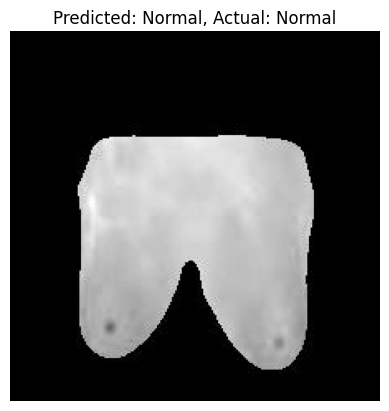

In [76]:
# Function to test a single image
def test_single_image(model, dataset, index):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Get the image and label from the dataset
        image, label = dataset[index]
        image = image.to(device)  # Move the image to the appropriate device

        # Add a batch dimension
        image = image.unsqueeze(0)  # Shape: [1, 1, height, width]

        # Get the model's prediction
        output = model(image)
        _, predicted = torch.max(output.data, 1)

        # Convert the predicted label to a human-readable format
        prediction = "Normal" if predicted.item() == 0 else "Cancer"

        # Display the image and prediction
        plt.imshow(image[0][0].cpu(), cmap='gray')  # Use 'gray' colormap for grayscale images
        plt.title(f"Predicted: {prediction}, Actual: {'Normal' if label == 0 else 'Cancer'}")
        plt.axis('off')
        plt.show()

# Example usage: Test a specific image from the validation dataset
test_index = 0  # Change this index to test different images
test_single_image(model, val_dataset, test_index)


In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from pennylane import numpy as np

# Define the quantum device
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]  # Measure Pauli-Z expectation values

# Define the QNN layer
class QNNLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QNNLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.qnode = qml.QNode(circuit, dev, interface="torch")

        # Initialize quantum layer weights (random for simplicity)
        self.weights = nn.Parameter(torch.randn(n_layers, n_qubits, 3))  # n_layers * n_qubits * 3 angles

    def forward(self, x):
        q_out = [self.qnode(sample, self.weights) for sample in x]
        q_out_tensor = torch.tensor(q_out, dtype=torch.float32, device=x.device)
        return q_out_tensor

class QuantumTransferLearningModel(nn.Module):
    def __init__(self):
        super(QuantumTransferLearningModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layer after CNN
        self.fc1 = nn.Linear(256 * 14 * 14, n_qubits)  # Flattened image size (224x224) -> n_qubits

        # Quantum Neural Network layer
        self.qnn = QNNLayer(n_qubits, 2)  # Quantum layer with n_qubits and 2 layers

        # Final fully connected layer for classification
        self.fc2 = nn.Linear(n_qubits, 2)  # Binary classification (normal vs abnormal)

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features using CNN
        x = x.view(x.size(0), -1)  # Flatten the feature map to a vector
        x = self.fc1(x)  # Pass through fully connected layer to match n_qubits
        x = self.qnn(x)  # Pass through the quantum layer
        x = self.fc2(x)  # Final classification layer
        return x

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QuantumTransferLearningModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:  # Assuming you have a DataLoader for training data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:  # Assuming you have a DataLoader for validation data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            # Forward pass
            val_outputs = model(val_inputs)

            # Compute loss
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss_avg = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss_avg:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Testing phase
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:  # Assuming you have a DataLoader for test data
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

            # Forward pass
            test_outputs = model(test_inputs)

            # Compute loss
            test_loss = criterion(test_outputs, test_labels)

            test_running_loss += test_loss.item()
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()

    test_loss_avg = test_running_loss / len(test_loader)
    test_accuracy = test_correct / test_total

    print(f"Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.4f}")



Epoch 1/30, Train Loss: 0.9097, Train Accuracy: 0.0000, Val Loss: 0.8495, Val Accuracy: 0.0000
Test Loss: 0.8495, Test Accuracy: 0.0000
Epoch 2/30, Train Loss: 0.7982, Train Accuracy: 0.0000, Val Loss: 0.7445, Val Accuracy: 0.0000
Test Loss: 0.7445, Test Accuracy: 0.0000
Epoch 3/30, Train Loss: 0.6994, Train Accuracy: 0.4174, Val Loss: 0.6525, Val Accuracy: 1.0000
Test Loss: 0.6525, Test Accuracy: 1.0000
Epoch 4/30, Train Loss: 0.6133, Train Accuracy: 1.0000, Val Loss: 0.5727, Val Accuracy: 1.0000
Test Loss: 0.5727, Test Accuracy: 1.0000
Epoch 5/30, Train Loss: 0.5389, Train Accuracy: 1.0000, Val Loss: 0.5039, Val Accuracy: 1.0000
Test Loss: 0.5039, Test Accuracy: 1.0000
Epoch 6/30, Train Loss: 0.4749, Train Accuracy: 1.0000, Val Loss: 0.4449, Val Accuracy: 1.0000
Test Loss: 0.4448, Test Accuracy: 1.0000
Epoch 7/30, Train Loss: 0.4200, Train Accuracy: 1.0000, Val Loss: 0.3943, Val Accuracy: 1.0000
Test Loss: 0.3942, Test Accuracy: 1.0000
Epoch 8/30, Train Loss: 0.3730, Train Accuracy: 